# N2V Prediction
Please run the 'N2V-Convallaria-1-Training' notebook first.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread

from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


## Convallaria

### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='ConvallariaData/Convallaria_diaphragm/'

# Load the test data
dataTest=imread(path+"20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[:,:512,:512]
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]


### Load the Network

In [3]:
# Load the network, created in the 'Convallaria-2-Training' notebook
net=torch.load(path+"/last_conv_N2V.net")

### Evaluation

image: 0
PSNR input 29.009240856174337
PSNR N2V 35.99136632149936
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR N2V 35.91992424296648
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR N2V 35.94726899807566
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR N2V 35.934609493626596
-----------------------------------
image: 4
PSNR input 29.002852113680238
PSNR N2V 35.93336716808927
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR N2V 35.94692307541527
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR N2V 35.97504077249908
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR N2V 35.96522323930487
-----------------------------------
image: 8
PSNR input 29.003677692102134
PSNR N2V 36.00677335795095
-----------------------------------
image: 9
PSNR input 28.991348421709475
PSNR N2V 35.97247014763719
----------------

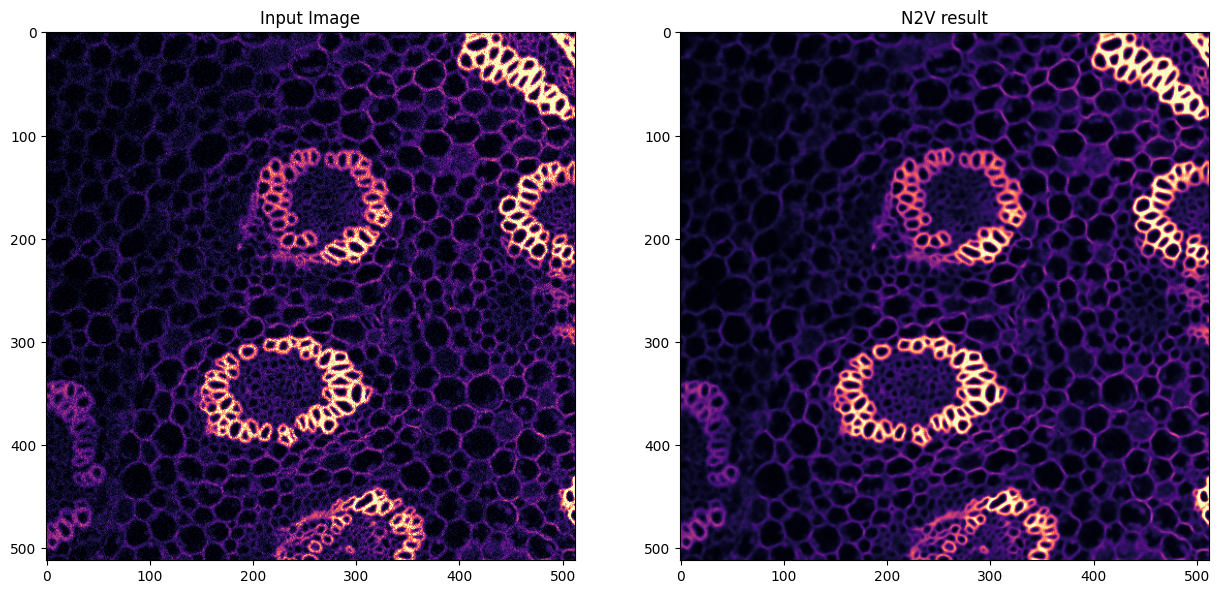

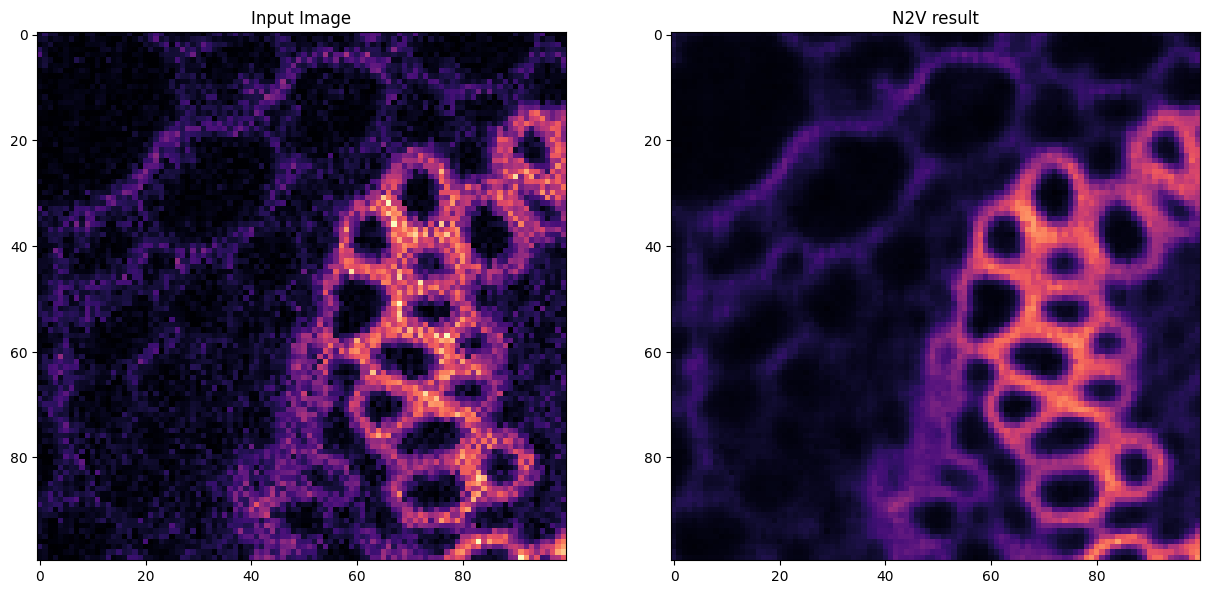

Avg PSNR: 35.952646277511754 +-(2SEM) 0.007006614084980554


In [4]:
# Now we are processing data and calculating PSNR values.
n2vRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    n2vResult = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    n2vPrior=PSNR(gt, n2vResult,rangePSNR )
    n2vRes.append(n2vPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR N2V",n2vPrior) # Without info from masked pixel
    print ('-----------------------------------')
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='N2V result')
plt.imshow(n2vResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='N2V result')
plt.imshow(n2vResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR:", np.mean(np.array(n2vRes) ), '+-(2SEM)',2*np.std(np.array(n2vRes) )/np.sqrt(float(len(n2vRes)) ) )

In [5]:
# We iterate over all test images.
for index in range(dataTest.shape[0]):
    im=dataTest[index]
    gt=dataTestGT[0]
    print((im - gt).std())

123.76349300773535
123.62451358453626
123.40798697217804
124.07648305380906
123.87498508694195
123.60295258123382
123.49237742625711
123.66014975756514
123.89583980279194
124.06191708482308
124.31435003234131
124.05110824923796
123.89885508510886
124.35264467195528
124.02598978985883
124.81683368505848
124.0026313624259
124.1596135773129
123.96592073199976
124.04068612084795
123.6922904270624
123.48731927759717
124.00414279038021
124.37382109287995
124.2839102633633
124.10738561251512
123.65663351358286
123.86302116079135
124.47049323600501
123.88772842580894
124.22934854356629
124.76201311759938
124.21275163152144
123.67975769423497
123.89035108056514
123.92725544675774
124.29426200125401
123.9748182520269
124.19408725180307
123.6959991173238
123.67318919143578
124.83475481880963
124.5697656667429
124.04313147734966
124.30531472013338
123.90977182264959
123.5549317462949
124.15678054552086
124.85235338224346
124.22598676707618
123.7825150591987
124.72144703819966
124.36879838065062
12

## Mouse

### Load Data

In [12]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='FMD/Confocal_MICE/raw/'

dataTest=np.load(path+'test_raw.npy').astype(np.float32)
dataTestGT=np.load(path+'../gt/test_gt.npy').astype(np.float32)

### Load the Network

In [13]:
# Load the network, created in the 'Convallaria-2-Training' notebook
net=torch.load(path+"last_N2V_conv_mouse0.net")

### Evaluation

In [16]:
im.shape

(512, 512)

image: 0
PSNR input 28.903582096099854
PSNR N2V 37.15708531817613
-----------------------------------
image: 1
PSNR input 28.89662265777588
PSNR N2V 37.024461451732655
-----------------------------------
image: 2
PSNR input 28.88657808303833
PSNR N2V 36.972362035846416
-----------------------------------
image: 3
PSNR input 28.898756504058838
PSNR N2V 37.115231611875956
-----------------------------------
image: 4
PSNR input 28.877415657043457
PSNR N2V 37.105908215570366
-----------------------------------
image: 5
PSNR input 28.891265392303467
PSNR N2V 37.002793624539756
-----------------------------------
image: 6
PSNR input 28.865532875061035
PSNR N2V 36.96820890319869
-----------------------------------
image: 7
PSNR input 28.88575315475464
PSNR N2V 37.06222755687688
-----------------------------------
image: 8
PSNR input 28.914501667022705
PSNR N2V 37.03175455699361
-----------------------------------
image: 9
PSNR input 28.826134204864502
PSNR N2V 36.96200031079324
--------------

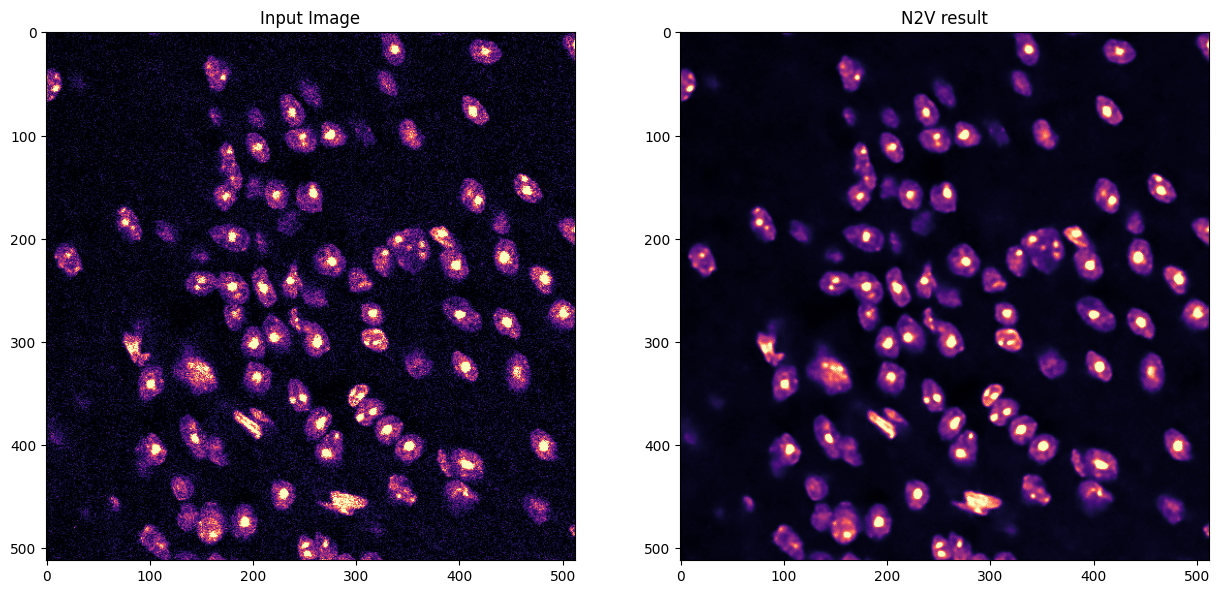

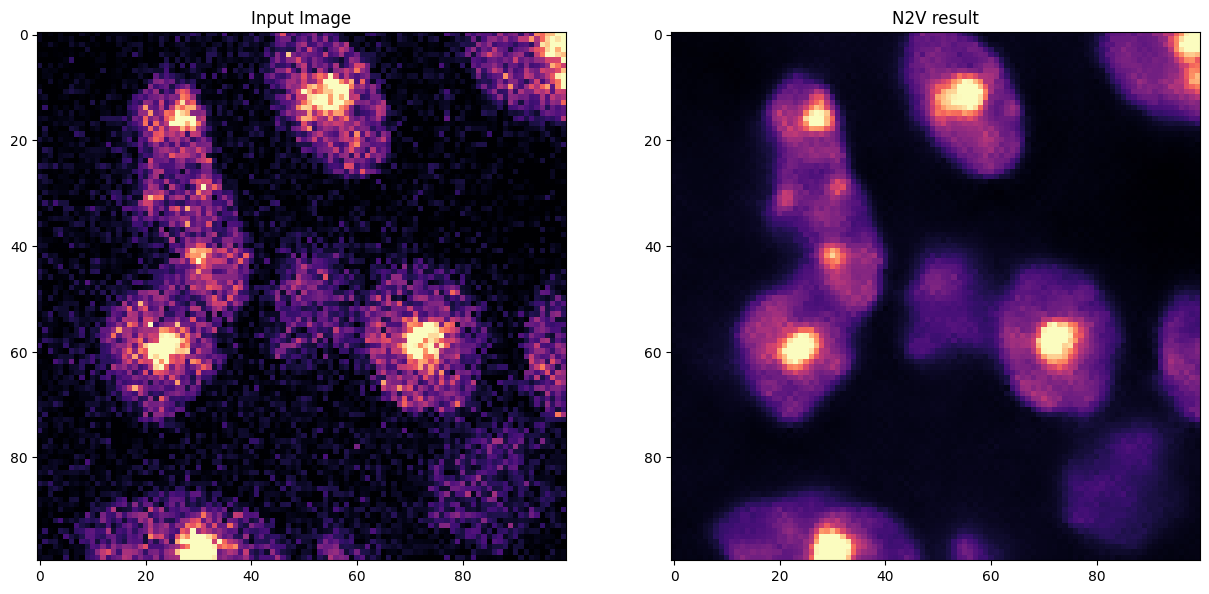

Avg PSNR: 37.05726224928352 +-(2SEM) 0.01930591165288571


In [14]:
# Now we are processing data and calculating PSNR values.
n2vRes=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    n2vResult = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    n2vPrior=PSNR(gt, n2vResult,rangePSNR )
    n2vRes.append(n2vPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR N2V",n2vPrior) # Without info from masked pixel
    print ('-----------------------------------')
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='N2V result')
plt.imshow(n2vResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='N2V result')
plt.imshow(n2vResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR:", np.mean(np.array(n2vRes) ), '+-(2SEM)',2*np.std(np.array(n2vRes) )/np.sqrt(float(len(n2vRes)) ) )

In [15]:
# We iterate over all test images.
for index in range(dataTest.shape[0]):
    im=dataTest[index]
    gt=dataTestGT[0]
    print((im - gt).std())

8.646451
8.653262
8.66326
8.651168
8.67253
8.658722
8.684412
8.664217
8.635467
8.723893
8.66781
8.651146
8.64549
8.621878
8.645572
8.683238
8.644625
8.66946
8.664376
8.679455
8.687576
8.665867
8.682215
8.67036
8.679724
8.7032995
8.662091
8.685878
8.637433
8.675368
8.642976
8.677059
8.677115
8.638352
8.632675
8.668601
8.631885
8.668506
8.651636
8.712783
8.659058
8.640165
8.674494
8.655593
8.620037
8.669741
8.677091
8.6399765
8.661291
8.689083
